In [1]:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.io as io
import matplotlib.pylab as plt
from pathlib import Path

8266217.206972408

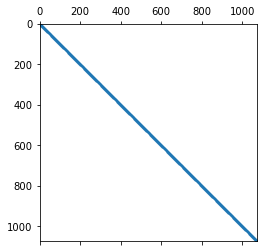

In [2]:
path = "~/Downloads/ch3-3-b2/"
path = "~/Downloads/farm/"
path = "~/Downloads/mesh1em1/"
path = "~/Downloads/b1_ss/"
path = "~/Downloads/pores_1/"
path = "~/Downloads/bcsstm02/"
path = "~/Downloads/bcsstm08/"
files = list(Path(path).expanduser().glob("*"))

fig, axs = plt.subplots(nrows=1, ncols=len(files))

for i, file in enumerate(files):
    A = io.mmread(file)
    ax = axs[i] if len(files) > 1 else axs
    ax.spy(A, markersize=1)

np.linalg.cond(A.toarray())

In [9]:
b = np.ones((A.shape[0]))
sol = linalg.spsolve(A, b)
np.linalg.norm(A @ sol - b)

7.771561172376096e-16

In [10]:
def cg(A, b):
    # x = np.random.rand(*b.shape)
    x = np.zeros(b.shape)
    r = b - A @ x
    rr = r.T.dot(r)
    p = r
    for k in range(1000):
        Ap = A @ p # A.dot(p)
        a = rr / p.T.dot(Ap)
        x = x + a * p
        r = r - a * Ap
        rr1 = r.T.dot(r)
        b = rr1 / rr
        rr = rr1
        p = r + b * p
    return x

cg_sol = cg(A, b)

print(A @ cg_sol - b)


[-4.4408921e-16 -4.4408921e-16 -4.4408921e-16 ... -4.4408921e-16
 -4.4408921e-16 -4.4408921e-16]


In [11]:
np.linalg.cond(A.toarray())

8266217.206972408

In [32]:
def check(x, b, numtests=5):
    for _ in range(numtests):
        xbad = x + np.random.normal(size=x.shape)
        d = np.linalg.norm(x-b)
        dbad = np.linalg.norm(xbad-b)
        assert dbad > d

def s_cg(A, b, s=4):
    x = np.zeros(b.shape)
    r = b - A @ x
    rr = r.T.dot(r)
    pp = []
    p = r
    for _ in range(s):
        pp.append(p)
        p = A @ p
    pp = np.vstack(pp)
    # print(f"{pp.shape=}")
    for _ in range(10):
        # print(f"{pp.shape=}")
        m = np.array([r @ p for p in pp])
        # print(f"{m.shape=}")
        # W_i @ a = m_i = [(r, p^1),... , (r, p^s)]
        W = np.array([[pj @ A @ pi.T for pj in pp] for pi in pp])
        # print(f"{W.shape=}")
        a = np.linalg.inv(W) @ m
        x = x + (a @ pp).reshape(*x.shape)
        check(x, b)
        tmp = b - A @ x
        # print(f"{tmp.shape=}")
        rs = []
        for i in range(s):
            rs.append(tmp)
            tmp = A @ tmp
        rs = np.vstack(rs)
        # print(f"{rs.shape=}")
        r = rs[0]
    return pp

s_cg(A, b)


array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [7.99000000e-01, 1.00000000e+03, 1.00000000e+03, ...,
        1.00000000e+03, 1.00000000e+03, 1.00000000e+03],
       [6.38401000e-01, 1.00000000e+06, 1.00000000e+06, ...,
        1.00000000e+06, 1.00000000e+06, 1.00000000e+06],
       [5.10082399e-01, 1.00000000e+09, 1.00000000e+09, ...,
        1.00000000e+09, 1.00000000e+09, 1.00000000e+09]])